In [70]:
import pymorphy2
import re
import os
import string
import glob
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter
from sklearn.model_selection import GridSearchCV

In [113]:
def num_of_words(len_of_win):
    expVectorData = []
    for i, token in enumerate(words):
        exampleVector = []
        j = -1 * len_of_win
        for _ in range(2*len_of_win+1):
            try:
                exampleVector.append(vectorData[i+j])
            except Exception:
                exampleVector.append([0 for i in range(27)])
            j = j + 1
        expVectorData.append(exampleVector)
    new_tags = tags.copy()
    for j, i in enumerate(new_tags):
        if i == 'name' or i == 'surname':
            new_tags[j] = 1
        else:
            new_tags[j] = 0
            
    new_expVectorData = []
    for i in expVectorData:
        temp = []
        for j in i:
            for k in j:
                temp.append(k)
        new_expVectorData.append(temp)
    
    print(len_of_win)

    X = np.array(new_expVectorData)
    y = np.array(new_tags)
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    sgd = SGDClassifier()
#    sgd.fit(X_train, y_train)
    return np.mean(cross_val_score(sgd, X, y, cv = 5, scoring = make_scorer(f1_score)))

1
2
3
4
5
6
7
8
9
10


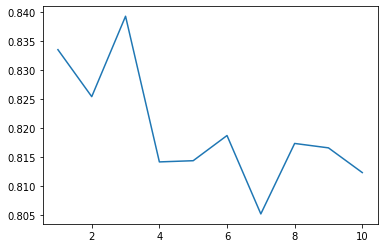

In [114]:
temp = []
for i in range(1, 11):
    temp.append(num_of_words(i))
plt.plot( range(1, 11), temp)

In [115]:
import nltk
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

temp = []

for word in tqdm(words):
        if 'Name' in morph.parse(word)[0].tag:
            temp.append(1)
        else:
            temp.append(0)
            
new_tags = tags.copy()
for j, i in enumerate(new_tags):
    if i == 'name' :
        new_tags[j] = 1
    else:
        new_tags[j] = 0
        
f1_score(temp, new_tags)

100%|███████████████████████████████████████████████████████████████████████████| 84696/84696 [01:57<00:00, 719.48it/s]


0.7666314677930305

In [116]:
morph = pymorphy2.MorphAnalyzer()
os.chdir(r"C:\Users\etrib\Documents\CourseWork\Data\testset")

In [117]:
docs = glob.glob('*.txt')
docslist = [i.split(sep = '.')[0] for i in docs]
words = ['start_token']
tags = ['start_state']

In [118]:
word_dict = {}
req_tokens = ['loc_name', 'org_name', 'name', 'surname', 'org_descr', 'loc_descr']
not_match = ['nickname', 'job', 'patronymic']

for doc in [open(i + '.tokens', encoding = 'utf-8').read().split(sep = '\n') for i in docslist]:
    for k in doc:
        k = k.split()
        if k:
            word = k[-1]
            ids = k[0]
            word_dict[ids] = [word] 
for doc in [open(i + '.spans', encoding = 'utf-8').read().split(sep = '\n') for i in docslist]:
    for k in doc:
        k = k.split()
        if k:
            word = k[-1]
            ids = k[-2]
            tok = k[1]
        if tok in req_tokens:
            if (ids in word_dict) and word_dict[ids][0] == word:
                word_dict[ids].append(tok)
        if tok in not_match:
            if (ids in word_dict) and word_dict[ids][0] == word:
                word_dict[ids].append('others') 
for k in word_dict:
    if len(word_dict[k]) != 2:
        word_dict[k].append('not_ne')
for k in word_dict:
    words.append(word_dict[k][0])
    tags.append(word_dict[k][1])

In [119]:
words.append("end_token")
tags.append("end_state")

In [120]:
for j, i in enumerate(tags):
    if i!= 'name' and i!='surname' and i != 'start_state' and i!= 'end_state':
        tags[j] = 'not_ne'
set(tags)

{'end_state', 'name', 'not_ne', 'start_state', 'surname'}

In [121]:
wordslist = []
taglist = []
for i, word in enumerate(tqdm(words)):
    if word in [".", "!", "?", "«", "»"]:
        if word in [".", "!", "?"] and words[i+1] not in ["«", "»"]:
            wordslist.append("end_token")
            taglist.append("end_state")
            wordslist.append("start_token")
            taglist.append("start_state")
        if word in ["«", "»"]:
            wordslist.append(word)
            taglist.append(tags[i])
    else:
        wordParse = morph.parse(word)[0]
        if "PNCT" not in wordParse.tag:
            wordslist.append(word)
            taglist.append(tags[i])
words = wordslist.copy()
tags = taglist.copy()

100%|███████████████████████████████████████████████████████████████████████████| 90324/90324 [01:43<00:00, 869.00it/s]


In [122]:
def wordtovec(word, idd):
    wordVector = [0 for i in range(27)]
        
    if word in ["start_token", "end_token", "«", "»"]:
        if word == "start_token":
            bracketCounter[word] += 1
            if bracketCounter[word] == 2:
                bracketCounter[word] = 1
        if word in ["«", "»"]:
            bracketCounter['bracket'] += 1
            if bracketCounter['bracket'] == 3:
                bracketCounter['bracket'] = 1
        return wordVector
        
    tag = morph.parse(word)[0].tag
    pos = morph.parse(word)[0].tag.POS
    
    if pos in ["NOUN", "ADJF", "ADJS", "VERB", "PREP", "CONJ"]: 
        if pos == 'NOUN':
            wordVector[0] = 1
        if pos == 'ADJF' or pos == 'ADJS':
            wordVector[1] = 1
        if pos == 'VERB':
            wordVector[2] = 1
        if pos == 'PREP':
            wordVector[3] = 1
        if pos == 'CONJ':
            wordVector[4] = 1
    else:
        wordVector[5] = 1
    if 'nomn' in tag:
        wordVector[6] = 1
    if 'gent' in tag:
        wordVector[7] = 1
    if 'datv' in tag:
        wordVector[8] = 1
    if 'accs' in tag:
        wordVector[9] = 1
    if 'ablt' in tag:
        wordVector[10] = 1
    if 'loct' in tag:
        wordVector[11] = 1
    if 'sing' in tag:
        wordVector[12] = 1
    if 'masc' in tag:
        wordVector[13] = 1
    if 'femn' in tag:
        wordVector[14] = 1
    if 'neut' in tag:
        wordVector[15] = 1    
    if len(word) > 1 and word[0].isupper() and word[1].islower():
        wordVector[16] = 1    
    if words[idd-1] == "start_token":
        wordVector[17] = 1    
    if words[idd+1] == "end_token":
        wordVector[18] = 1        
    if word.isupper():
        wordVector[19] = 1
    if word.islower():
        wordVector[20] = 1
    if bracketCounter["start_token"] == 1 and bracketCounter["bracket"] == 1:
        wordVector[21] = 1
    if 'anim' in tag:
        wordVector[22] = 1
    if "-" in word:
        wordVector[23] = 1
    if word.isdigit():
        wordVector[24] = 1        
    if tags[idd] == 'loc_descr':
        wordVector[25] = 1
        tags[idd] = 'not_ne'
        
    if tags[idd] == 'org_descr':
        wordVector[26] = 1
        tags[idd] = 'not_ne'
        
    return wordVector  


In [123]:
bracketCounter = {"start_token":0, "bracket":0}

wordvec = []
for i, word in enumerate(tqdm(words)):
    temp = []
    temp = wordtovec(word, i)
    wordvec.append(temp)


100%|███████████████████████████████████████████████████████████████████████████| 84696/84696 [03:30<00:00, 402.48it/s]


In [124]:
len_of_win = 3
vec_data = []
for i, token in enumerate(tqdm(words)):
    exvec = []
    j = -1 * len_of_win
    for _ in range(2*len_of_win+1):
        try:
            exvec.append(wordvec[i+j])
        except Exception:
            exvec.append([0 for i in range(27)])
        j = j + 1
    vec_data.append(exvec)

100%|█████████████████████████████████████████████████████████████████████████| 84696/84696 [00:01<00:00, 52139.75it/s]


In [125]:
len(vec_data)

84696

In [126]:
state_dict = {'start':0, 'end':0}
sentVector = []
sentDictFeatures = []
for i, token in enumerate(words):
    if token == 'start_token':
        state_dict['start'] += 1
        if state_dict['start'] == 2:
            state_dict['start'] = 1
    if token == 'end_token':
        state_dict['end'] += 1

    if state_dict['start'] == 1 and state_dict['end'] == 0 and token != 'start_token':
        wordVector = vectorData[i]
        features = { str(k) : wordVector[k] for k in range(0, len(wordVector) ) }
        sentVector.append(features)
    if state_dict['end'] == 1:
        state_dict['end'] = 0
        sentDictFeatures.append(sentVector)
        sentVector = []

In [156]:
state_dict = {'start':0, 'end':0}
sentVector = []
sentTagVectors = []
for tag in tags:
    if tag == 'start_state':
        state_dict['start'] += 1
        #print('предложение ' , i+1, ' началось')
        if state_dict['start'] == 2:
            state_dict['start'] = 1
    if tag == 'end_state':
        state_dict['end'] += 1

    if state_dict['start'] == 1 and state_dict['end'] == 0 and tag != 'start_state':
        sentVector.append(tag)
    if state_dict['end'] == 1:
        state_dict['end'] = 0
        sentTagVectors.append(sentVector)
        sentVector = []
temp = []
for i in sentTagVectors:
    temp.append(i)
len(temp)

4184

In [128]:
new_vec_data = []
for i in tqdm(vec_data):
    temp = []
    for j in i:
        for k in j:
            temp.append(k)
    new_vec_data.append(temp)
len(new_vec_data)

100%|██████████████████████████████████████████████████████████████████████████| 84696/84696 [00:13<00:00, 6242.58it/s]


84696

In [157]:
#Conditional Random Fields (CRFs)
X_crf = sentDictFeatures
y_crf = sentTagVectors
X_crf_train, X_crf_test, y_crf_train, y_crf_test = train_test_split(X_crf, y_crf, test_size=0.1)

for i in y_crf_test:
    for j, k in enumerate(i):
        if k == 'not_ne':
            i[j] = '0'
        else:
            i[j] = '1'
            
for i in y_crf_train:
    for j, k in enumerate(i):
        if k == 'not_ne':
            i[j] = '0'
        else:
            i[j] = '1'

            
y = np.array(['0','1'])
classes = np.unique(y)
classes = classes.tolist()
new_classes = classes.copy()

f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=new_classes)

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100
)
crf.fit(X_crf_train,
        y_crf_train)

y_crf_pred = crf.predict(X_crf_test)
print(metrics.flat_classification_report(y_crf_test, y_crf_pred, labels = new_classes))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6965
           1       0.89      0.78      0.84       372

    accuracy                           0.98      7337
   macro avg       0.94      0.89      0.91      7337
weighted avg       0.98      0.98      0.98      7337



In [69]:
crf = sklearn_crfsuite.CRF()
tuned_parameters = {
    'c1': [(i+1)*0.05 for i in range(-5, 10)],
    'c2': [(i+1)*0.05 for i in range(-5, 10)]
}
model_crf = GridSearchCV(crf, tuned_parameters, scoring = make_scorer(metrics.flat_f1_score, average='weighted'), cv=2)
model_crf.fit(X_crf, y_crf)
model_crf.best_params_

KeyboardInterrupt: 

In [135]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB


new_tags = tags.copy()
for j, i in enumerate(new_tags):
    if i == 'name' or i == 'surname':
        new_tags[j] = 1
    else:
        new_tags[j] = 0

X = np.array(new_expVectorData)
y = np.array(new_tags)
        
classes = np.unique(y)
classes = classes.tolist()
new_classes = classes.copy()
#new_classes.remove('end_state')
#new_classes.remove('start_state')
#new_classes.remove('start_state')
print(new_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, y_train.shape

sgd = SGDClassifier(**model.best_params_)
sgd.fit(X_train, y_train)
#print(classification_report(y_pred=sgd.predict(X_test), y_true=y_test, labels=new_classes))
f1_score(sgd.predict(X_test), y_test)
np.mean(cross_val_score(sgd, X, y, cv = 5, scoring = make_scorer(f1_score)))

[0, 1]


0.8288043172560409

In [131]:
sgd = SGDClassifier()
tuned_parameters = {
    'max_iter': [700 + i*50 for i in range(1, 10)],
    'alpha': [0.0001,0.001, 0.01, 0.1, 1, 10]
}
model = GridSearchCV(sgd, tuned_parameters, scoring = make_scorer(f1_score), cv=2)
model.fit(X_train, y_train)
model.best_params_

C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

{'alpha': 0.001, 'max_iter': 750}

In [134]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

new_tags = tags.copy()
for j, i in enumerate(new_tags):
    if i == 'name' or i == 'surname':
        new_tags[j] = 1
    else:
        new_tags[j] = 0

X = np.array(new_expVectorData)
y = np.array(new_tags)
        
classes = np.unique(y)
classes = classes.tolist()
new_classes = classes.copy()
#new_classes.remove('end_state')
#new_classes.remove('start_state')
#new_classes.remove('start_state')
print(new_classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, y_train.shape

#Linear classifiers with SGD training
#sgd = SGDClassifier(max_iter=1000 , n_iter_no_change = 1000)
#sgd.partial_fit(X_train, y_train, classes)
#print(classification_report(y_pred=sgd.predict(X_test), y_true=y_test, labels=new_classes))

tree = DecisionTreeClassifier(**model_tree.best_params_)
tree.fit(X_train, y_train)
#print(classification_report(y_pred=sgd.predict(X_test), y_true=y_test, labels=new_classes))
f1_score(tree.predict(X_test), y_test)
np.mean(cross_val_score(tree, X, y, cv = 5, scoring = make_scorer(f1_score)))

[0, 1]


0.7979583357251934

In [133]:
tree = DecisionTreeClassifier()
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'], 
    'max_depth': [i for i in range(1, 181, 20)]
}
model_tree = GridSearchCV(tree, tuned_parameters, scoring = make_scorer(f1_score), cv=2)
model_tree.fit(X_train, y_train)
model_tree.best_params_

C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

{'criterion': 'entropy', 'max_depth': 101, 'splitter': 'best'}

In [152]:
print(len(tree.feature_importances_))
temp = list(zip(range(1, 406), tree.feature_importances_))
temp.sort(key = lambda x: x[1], reverse = True)
temp

405


[(206, 0.4877091865383624),
 (212, 0.2007043711292018),
 (179, 0.02804225298354984),
 (207, 0.01962396456998924),
 (203, 0.012873112589778836),
 (185, 0.012442712854077824),
 (233, 0.009892567291415043),
 (202, 0.007943783683965326),
 (209, 0.007127942071165445),
 (175, 0.006891121877241599),
 (288, 0.005424452892842912),
 (197, 0.004898929838981856),
 (224, 0.004406592376917556),
 (230, 0.0027462993839440734),
 (167, 0.0023934575752093943),
 (158, 0.002382488260176882),
 (260, 0.002364116305937557),
 (178, 0.0022616574077429508),
 (33, 0.0022567692517141244),
 (219, 0.002234804540593583),
 (237, 0.002170474413010081),
 (163, 0.002158828288960738),
 (131, 0.0021183272711280537),
 (104, 0.0018782624090303928),
 (278, 0.0018603564461082687),
 (239, 0.0017662276049801489),
 (148, 0.0017628813292589122),
 (284, 0.0017193600357596254),
 (213, 0.0016703341572058502),
 (217, 0.001629107801114352),
 (201, 0.0016289171243829075),
 (190, 0.001617082322073469),
 (128, 0.0016147430289218418),
 (33

In [154]:
weights = []
for i in sgd.coef_:
    for j in i:
        weights.append(j)
weights = np.array(weights)
weights = weights/np.sum(weights)
weights
temp = list(zip(range(1, 406), weights))
temp.sort(key = lambda x: abs(x[1]), reverse = True)
temp

[(206, 0.0685005393743245),
 (212, 0.06564185544767957),
 (210, -0.0327939590075516),
 (179, 0.023894282632146772),
 (233, 0.021089536138079793),
 (202, 0.019848975188781082),
 (185, 0.016936353829557705),
 (165, 0.015695792880258897),
 (195, 0.014239482200647259),
 (239, 0.014239482200647236),
 (167, 0.013754045307443383),
 (190, 0.01272923408845745),
 (221, 0.01272923408845742),
 (191, 0.012675296655879216),
 (208, 0.011920172599784297),
 (288, 0.011812297734627877),
 (168, 0.011812297734627865),
 (235, 0.011812297734627863),
 (213, -0.011218985976267574),
 (209, 0.011218985976267573),
 (217, -0.011165048543689394),
 (72, 0.010841423948220111),
 (128, 0.010625674217907258),
 (203, 0.01040992448759447),
 (198, 0.010409924487594426),
 (343, 0.010302049622437987),
 (219, 0.010140237324703386),
 (160, 0.010140237324703379),
 (131, 0.009762675296655893),
 (201, -0.009223300970873805),
 (163, 0.009169363538295604),
 (315, 0.0091154261057174),
 (224, -0.009061488673139183),
 (175, 0.0088996